In [2]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-06-09 09:17:06.499898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
random.seed(18)
print(random.random())

0.18126486333322134


In [4]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [8]:
# drop the string values
train_df = train_init.drop(columns=["DepMap_ID", "age_and_sex"])
test_df = test_init.drop(columns=["DepMap_ID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(751, 1000)


,GPX4 (2879),CCND1 (595),EP300 (2033),CDK6 (1021),TXNRD1 (7296),ITGAV (3685),TYMS (7298),RIC1 (57589),STX4 (6810),SDHB (6390),...,GPR61 (83873),ENSA (2029),NCOA6 (23054),RAC1 (5879),MRPS22 (56945),VCL (7414),EXOC2 (55770),FABP5 (2171),LSM10 (84967),IFITM2 (10581)
0,0.940381,0.990926,0.000553,0.359180,0.967980,0.990922,0.137612,0.729464,0.059158,0.035206,...,0.716783,0.286511,0.031247,0.998153,0.100166,0.881757,0.464951,0.036607,0.860684,0.178508
1,0.977704,0.978002,0.893363,0.404650,0.934863,0.968326,0.147697,0.922680,0.038857,0.029896,...,0.404220,0.370852,0.773730,0.909492,0.447132,0.448574,0.343470,0.786135,0.276141,0.195710
2,0.939975,0.039721,0.933913,0.944452,0.819059,0.102276,0.983097,0.387890,0.087310,0.952576,...,0.332486,0.448683,0.133314,0.350446,0.832741,0.145942,0.052924,0.868234,0.294384,0.419293


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(133, 1000)


,GPX4 (2879),CCND1 (595),EP300 (2033),CDK6 (1021),TXNRD1 (7296),ITGAV (3685),TYMS (7298),RIC1 (57589),STX4 (6810),SDHB (6390),...,GPR61 (83873),ENSA (2029),NCOA6 (23054),RAC1 (5879),MRPS22 (56945),VCL (7414),EXOC2 (55770),FABP5 (2171),LSM10 (84967),IFITM2 (10581)
0,0.958795,0.956562,0.065556,0.652089,0.013551,0.904227,0.079523,0.056452,0.163706,0.010778,...,0.830012,0.675331,0.888964,0.947275,0.428821,0.802744,0.226727,0.940660,0.337393,0.147007
1,0.474103,0.995809,0.493091,0.324534,0.825609,0.280193,0.948674,0.968149,0.709961,0.921780,...,0.752857,0.219295,0.181090,0.934329,0.912023,0.273095,0.241361,0.642029,0.931141,0.564838
2,0.999218,0.999975,0.001974,0.115929,0.387753,0.200597,0.731629,0.994617,0.118876,0.099596,...,0.462767,0.448056,0.027778,0.337720,0.905973,0.166793,0.464052,0.399451,0.971522,0.519509


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=100,
    batch_size=112,
    encoder_batch_norm=True,
    epochs=905,
    learning_rate=0.005,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=10,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-06-05 09:57:36.615191: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/905
7/7 [==============================] - 2s 97ms/step - loss: 954.0083 - recon: 486.8191 - kl: 467.1893 - val_loss: 10024.4375 - val_recon: 3409.1233 - val_kl: 6615.3140
Epoch 2/905
7/7 [==============================] - 0s 51ms/step - loss: 577.0286 - recon: 230.0098 - kl: 347.0189 - val_loss: 19148.0234 - val_recon: 3604.1707 - val_kl: 15543.8525
Epoch 3/905
7/7 [==============================] - 0s 46ms/step - loss: 443.1964 - recon: 163.5819 - kl: 279.6146 - val_loss: 15965.0371 - val_recon: 3772.5317 - val_kl: 12192.5068
Epoch 4/905
7/7 [==============================] - 0s 43ms/step - loss: 373.1768 - recon: 139.0313 - kl: 234.1456 - val_loss: 7022.6265 - val_recon: 1276.2507 - val_kl: 5746.3755
Epoch 5/905
7/7 [==============================] - 0s 24ms/step - loss: 328.0829 - recon: 125.9063 - kl: 202.1765 - val_loss: 5153.3916 - val_recon: 1790.5815 - val_kl: 3362.8098
Epoch 6/905
7/7 [==============================] - 0s 31ms/step - loss: 293.2488 - recon: 114.2605 -

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

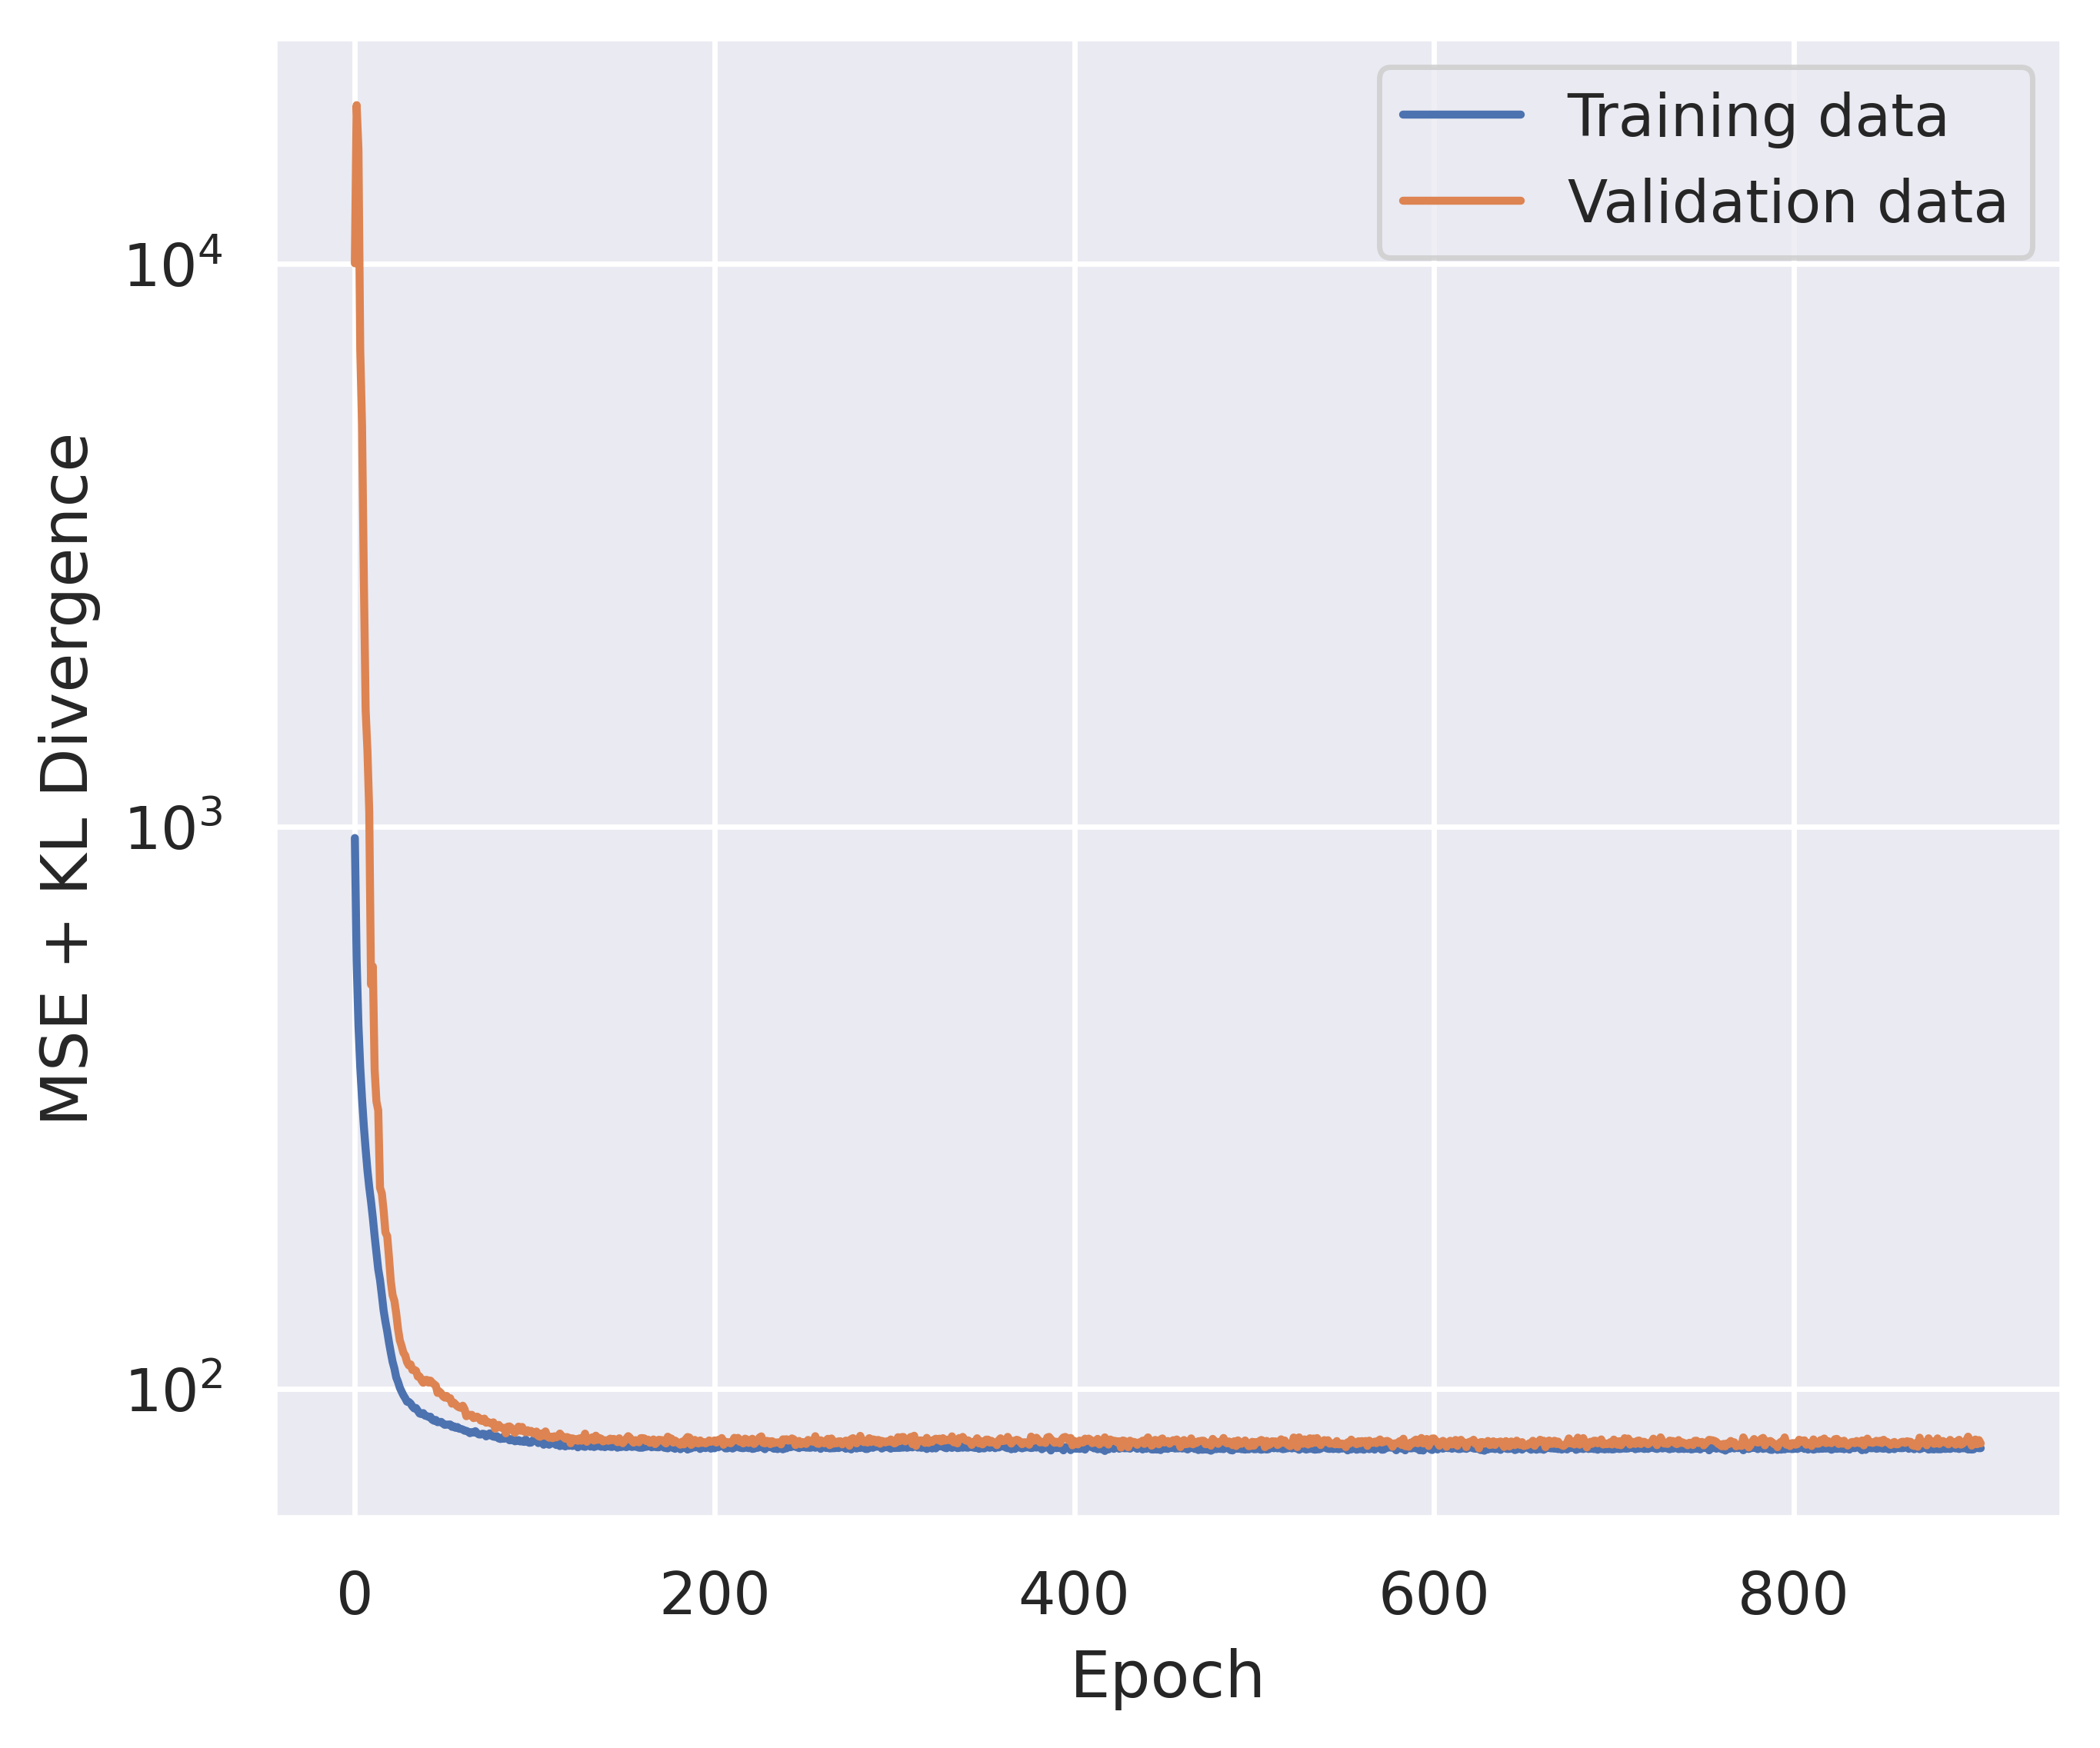

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
#Need to add code here to close those model


In [15]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [16]:
data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [17]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [18]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["age_category", "sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    DepMap_ID=train_and_test.DepMap_ID.astype(str),
    age_category=train_and_test.age_category.astype(str),
    sex=train_and_test.sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,DepMap_ID,age_category,sex,train_or_test
0,ACH-001623,Adult,Female,train
1,ACH-001715,Pediatric,Male,train
2,ACH-000588,Adult,Male,train
3,ACH-001212,Pediatric,Female,train
4,ACH-000222,Adult,Female,train
...,...,...,...,...
879,ACH-002298,Adult,Male,test
880,ACH-000213,Adult,Male,test
881,ACH-000181,Adult,Male,test
882,ACH-000237,Adult,Female,test


In [19]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the DepMap IDs added back in
extracted_col = metadata['DepMap_ID']

latent_df.insert(0, 'DepMap_ID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

28/28 [==============================] - 0s 1ms/step


,DepMap_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,ACH-001623,0.053813,-0.077198,-0.337804,-0.128900,1.113143,-0.382460,0.538895,0.525934,0.879386,...,-1.162678,0.178479,0.568191,-1.568353,1.199618,0.752992,1.524265,0.094660,-0.046069,-1.012368
1,ACH-001715,0.778090,-1.053276,-0.433644,-0.317039,-0.300648,-0.499756,0.067160,1.570380,1.095022,...,1.329341,0.744561,-2.368924,-0.211304,0.781237,-0.785359,0.906711,0.384475,0.473556,-0.547058
2,ACH-000588,-0.368384,0.585622,0.152950,0.102797,1.554580,-0.329583,0.432814,-1.371131,-0.295116,...,0.871602,0.418651,0.807426,-1.715049,-0.700452,0.045911,0.665777,2.265712,-0.898117,0.552546
3,ACH-001212,-0.184805,1.373711,-0.592571,-0.275743,-0.020670,-1.472439,-0.991704,-1.518867,0.860327,...,-1.000101,-1.219701,-0.656118,-0.106557,-0.353127,-0.315068,-1.045117,-0.213707,0.146057,1.081205
4,ACH-000222,-0.936708,0.768611,0.177226,0.524434,0.410921,-0.004372,-0.774023,0.648857,-0.295055,...,-2.157320,1.128564,0.128261,-0.564045,-0.517148,-0.427095,1.520731,-0.877977,0.011061,-0.148258


In [23]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.003431,-0.066462,0.023348,-0.087693,-0.035378,-0.130166,-0.011303,0.002215,0.065100,0.010739,...,-0.122327,-0.089983,0.008672,-0.032056,-0.070818,-0.042180,-0.043921,0.070101,-0.021080,-0.009599
1,0.041190,-0.036413,-0.073804,-0.003457,0.214047,0.094045,-0.096939,-0.046628,0.055162,-0.014838,...,0.073669,0.104024,0.006950,0.009301,0.074342,-0.054289,0.122823,-0.103081,-0.096315,0.040273
2,0.042926,-0.047306,-0.007981,0.092379,-0.049409,-0.051858,-0.000272,-0.015936,-0.088256,0.053242,...,-0.071827,-0.009377,0.067449,-0.054565,0.000477,-0.000918,-0.092843,0.085447,-0.072340,0.031898
3,0.025111,-0.041455,-0.056006,0.023690,-0.043088,-0.094552,0.011754,-0.006810,-0.007835,0.055285,...,-0.105212,-0.081106,0.022533,-0.052183,-0.101708,-0.038274,-0.148809,-0.038718,-0.024035,0.003900
4,0.000167,-0.018388,-0.069532,-0.096174,-0.059824,-0.032566,0.070643,0.013985,-0.008484,-0.067908,...,0.083347,0.030248,0.009382,0.011457,-0.023764,-0.003427,-0.043586,-0.049834,-0.042049,0.007481


In [21]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,GPX4,-0.003431,-0.066462,0.023348,-0.087693,-0.035378,-0.130166,-0.011303,0.002215,0.065100,...,-0.122327,-0.089983,0.008672,-0.032056,-0.070818,-0.042180,-0.043921,0.070101,-0.021080,-0.009599
1,CCND1,0.041190,-0.036413,-0.073804,-0.003457,0.214047,0.094045,-0.096939,-0.046628,0.055162,...,0.073669,0.104024,0.006950,0.009301,0.074342,-0.054289,0.122823,-0.103081,-0.096315,0.040273
2,EP300,0.042926,-0.047306,-0.007981,0.092379,-0.049409,-0.051858,-0.000272,-0.015936,-0.088256,...,-0.071827,-0.009377,0.067449,-0.054565,0.000477,-0.000918,-0.092843,0.085447,-0.072340,0.031898
3,CDK6,0.025111,-0.041455,-0.056006,0.023690,-0.043088,-0.094552,0.011754,-0.006810,-0.007835,...,-0.105212,-0.081106,0.022533,-0.052183,-0.101708,-0.038274,-0.148809,-0.038718,-0.024035,0.003900
4,TXNRD1,0.000167,-0.018388,-0.069532,-0.096174,-0.059824,-0.032566,0.070643,0.013985,-0.008484,...,0.083347,0.030248,0.009382,0.011457,-0.023764,-0.003427,-0.043586,-0.049834,-0.042049,0.007481
